# Nueral Networks in Python/Numpy/Cupy

I had a few goals for this project.  The main goal were to gain better intuition for neural networks by building one only using python and numpy.  A secondary goal was to gain better understanding of Object Oriented Programming by building a NN OOP style.  Lastly, I wanted to explore GPU acceleration by using Cupy (essentially a gpu accelearted version of Numpy).

### Imports

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

### Helper function to load data

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #test set labels

    classes = np.array(test_dataset["list_classes"][:]) #list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 1. It's a cat picture.


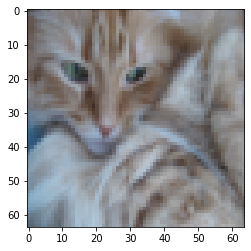

In [4]:
# Example of a picture
index = 2
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
n_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
n_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(n_train))
print ("Number of testing examples: " + str(n_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
input_features = train_x.shape[0]


print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print(train_x[1][0])

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
0.12156862745098039


In [10]:
np.random.seed(1)
class Layers_Dense:
    def __init__(self, x_features, n_neurons,num_examples,init='xavier',learning_rate=0.001):
        self.learning_rate=learning_rate
        self.m = num_examples
        if init == 'random':
            self.weights = np.random.randn(x_features,n_neurons) * 0.010         
        elif init == 'he':
            self.weights = np.random.randn(x_features,n_neurons)*np.sqrt(2./x_features)
        elif init == 'xavier':
            self.weights = np.random.randn(x_features,n_neurons)*np.sqrt(1./x_features)
        self.biases = np.zeros((n_neurons,1))
    def forward(self,x):
        self.output = np.dot(self.weights.T,x) + self.biases
        self.A_prev = x #problem here need the activation
    def backward(self,dZ):
        self.dW = (1/self.m)*(np.dot(dZ,self.A_prev.T))
        self.db = np.sum(dZ,axis=1,keepdims=True)/self.m
        self.dA = np.dot(self.weights,dZ)
        self.weights = self.weights + self.dW.T *-self.learning_rate
        self.biases = self.biases + self.db *-self.learning_rate

        
class ReLU:
    def forward(self, x):
        self.output = np.maximum(0,x)
        self.x = x
    def backward(self,dA):
        dZ = np.array(dA, copy=True)
        dZ[self.x <= 0] = 0
        self.dZ = dZ
        assert (dZ.shape == self.x.shape)
               
class Sigmoid:
    def forward(self, z):
        self.output = 1/(1+np.exp(-z))
    def backward(self):
        derivative = self.output * (1 - self.output)
        self.dZ = (self.dA_last * derivative)

    #sigmoid cross entropy
    def compute_cost(self,Y):
        m = Y.shape[1]
        self.cost = (-1/m)*(np.sum(Y*np.log(self.output)+(1-Y)*np.log(1-self.output)))
        self.dA_last = - (np.divide(Y, self.output) - np.divide(1 - Y, 1 - self.output))
        
class Softmax:
    def forward(self,x):
        x_exp = np.exp(x)
        x_sum = np.sum(x_exp, axis=1, keepdims=True)
        self.output = x_exp/x_sum
    def derivative(self):
        s = self.output.reshape(-1,1)
        self.ds = np.diagflats(s) - np.dot(s,s.T)


class Flatten:
    """Reshapes (l,h,d) image into (l*h*d,1)""" #might need work.  Currently dims first.
    def forward(self,x):
        self.output = x.reshape(x.shape[0]*x.shape[1]*x.shape[2],1)
        
class Normalize:
    def normalize_rows(self,x):
        x_norm = np.linalg.norm(x,axis=1,ord=2,keepdims=True)
        self.output = x/x_norm
    def normalize_columns(self,x):
        x_norm = np.linalg.norm(x,axis=0,ord=2,keepdims=True)
        self.output = x/x_norm

# Still testing
# class Leaky_ReLU:
#     def __init__(self,alpha):
#         self.leaky_slope = alpha
#     def forward(self,x):
#         self.x = x
#         self.output = np.maximum(self.leaky_slope*x,x)
#     def derivative(self):
#         d = np.zeros_like(self.x)
#         d[self.x<=0]=self.leaky_slope
#         d[self.x>0]=1
#         self.dl = d
        
# class Tanh:
#     def forward(self, x):
#         self.output = np.tanh(x)
#     def derivative(self):
#         self.dt = (1-(np.square(self.output)))
                
# class L1_Loss:
#     def loss(self,predictions,Y):
#         self.loss = np.sum(np.abs(Y - predictions))
        
# class L2_Loss:
#     def loss(self,predictions,Y):
#         self.loss = np.sum(np.dot(Y-predictions,Y-predictions))

In [11]:
#Instantiate Model
layer1 = Layers_Dense(12288,20,n_train,init='he',learning_rate = 0.0075)
activation1 = ReLU()
layer2 = Layers_Dense(20,7,n_train,init='he',learning_rate = 0.0075)
activation2 = ReLU()
layer3 = Layers_Dense(7,5,n_train,init='he',learning_rate = 0.0075)
activation3 = ReLU()
layer4 = Layers_Dense(5,1,n_train,init='xavier',learning_rate = 0.0075)
sigmoid = Sigmoid()

def predict(x_test):
    m = x_test.shape[1]
    Y_prediction = np.zeros((1,m))
    
    layer1.forward(x_test)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    predictions = sigmoid.output
    
    for i in range(predictions.shape[1]):
        if predictions[0][i] <= 0.5:
            Y_prediction[0][i] = 0
            #print('less than')
            #print(A[0][i])
        elif predictions[0][i] > 0.5:
            Y_prediction[0][i] = 1
    
    return Y_prediction

Iteration 0 cost: 0.002730 | Accuracy: 100.0 %
Iteration 100 cost: 0.002563 | Accuracy: 100.0 %
Iteration 200 cost: 0.002408 | Accuracy: 100.0 %
Iteration 300 cost: 0.002273 | Accuracy: 100.0 %
Iteration 400 cost: 0.002147 | Accuracy: 100.0 %
Iteration 500 cost: 0.002034 | Accuracy: 100.0 %
Iteration 600 cost: 0.001931 | Accuracy: 100.0 %
Iteration 700 cost: 0.001837 | Accuracy: 100.0 %
Iteration 800 cost: 0.001750 | Accuracy: 100.0 %
Iteration 900 cost: 0.001671 | Accuracy: 100.0 %
Iteration 1000 cost: 0.001597 | Accuracy: 100.0 %
Iteration 1100 cost: 0.001530 | Accuracy: 100.0 %
Iteration 1200 cost: 0.001466 | Accuracy: 100.0 %
Iteration 1300 cost: 0.001408 | Accuracy: 100.0 %
Iteration 1400 cost: 0.001353 | Accuracy: 100.0 %
Iteration 1500 cost: 0.001302 | Accuracy: 100.0 %
Iteration 1600 cost: 0.001254 | Accuracy: 100.0 %
Iteration 1700 cost: 0.001210 | Accuracy: 100.0 %
Iteration 1800 cost: 0.001168 | Accuracy: 100.0 %
Iteration 1900 cost: 0.001128 | Accuracy: 100.0 %
Iteration 20

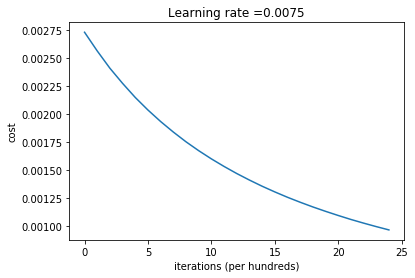

test accuracy: 74.0 %


In [17]:
np.random.seed(1)
costs = []
tic = time.perf_counter()
for i in range(2500):
    layer1.forward(train_x)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    sigmoid.compute_cost(train_y)
    sigmoid.backward()
    layer4.backward(sigmoid.dZ)
    activation3.backward(layer4.dA)
    layer3.backward(activation3.dZ)
    activation2.backward(layer3.dA)
    layer2.backward(activation2.dZ)
    activation1.backward(layer2.dA)
    layer1.backward(activation1.dZ)
    

    if i % 100 == 0:
        costs.append(sigmoid.cost)
        predictions = predict(train_x)
        print('Iteration %d cost: %f' %(i, sigmoid.cost),"|",
             'Accuracy: {} %'.format(100 - np.mean(np.abs(predictions - train_y)) * 100))
        
toc = time.perf_counter()

print(f"Training time: {toc - tic:0.4f} seconds")
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(layer1.learning_rate))
plt.show()

predictions = predict(test_x)
print("test accuracy: {} %".format(100 - np.mean(np.abs(predictions - test_y)) * 100))

## Now for the GPU accelerated version using CUPY!

In [25]:
import cupy as cp

In [26]:
train_x = cp.array(train_x)
test_x = cp.array(test_x)
test_y = cp.array(test_y)
train_y = cp.array(train_y)

In [14]:
class Layers_Dense():
    def __init__(self, x_features, n_neurons,num_examples,init='xavier',learning_rate=0.001):
        cp.random.seed(1)
        self.lr = learning_rate
        self.m = num_examples
        if init == 'random':
            self.W = cp.random.randn(x_features,n_neurons) * 0.01         
        elif init == 'he':
            self.W = cp.random.randn(x_features,n_neurons)*cp.sqrt(2./x_features)
        elif init == 'xavier':
            self.W = cp.random.randn(x_features,n_neurons)*cp.sqrt(1./x_features)
        self.b = cp.zeros((n_neurons, 1))
    def forward(self,x):
        self.output = cp.dot(self.W.T, x) + self.b
        self.A_prev = x #problem here need the activation
    def backward(self,dZ):
        self.dW = (1 / self.m)*(cp.dot(dZ, self.A_prev.T))
        self.db = cp.sum(dZ, axis=1 ,keepdims=True) / self.m
        self.dA = cp.dot(self.W, dZ)
        self.W = self.W + self.dW.T * -self.lr
        self.b = self.b + self.db * -self.lr

        
class ReLU:
    def forward(self, x):
        self.output = cp.maximum(0,x)
        self.x = x
    def backward(self,dA):
        dZ = cp.array(dA, copy=True)
        dZ[self.x <= 0] = 0
        self.dZ = dZ
        assert (dZ.shape == self.x.shape)

class Sigmoid:
    def forward(self, z):
        self.output = 1/(1+cp.exp(-z))
    def backward(self,Y):
        #derivative = self.output * (1 - self.output)
        #self.dZ = (self.dA_last * derivative)
        self.dZ = self.output - Y

    #sigmoid cross entropy
    def compute_cost(self,Y):
        m = Y.shape[1]
        self.cost = (-1/m)*(cp.sum(Y*cp.log(self.output)+(1-Y)*cp.log(1-self.output)))
        #self.dA_last = - (cp.divide(Y, self.output) - cp.divide(1 - Y, 1 - self.output))


In [28]:
#Instantiate Model
learning_rate = 0.0065
layer1 = Layers_Dense(12288,20,m_train,init='he',learning_rate = learning_rate)
activation1 = ReLU()
layer2 = Layers_Dense(20,7,m_train,init='he',learning_rate = learning_rate)
activation2 = ReLU()
layer3 = Layers_Dense(7,5,m_train,init='he',learning_rate = learning_rate)
activation3 = ReLU()
layer4 = Layers_Dense(5,1,m_train,init='xavier',learning_rate = learning_rate)
sigmoid = Sigmoid()
 
def predict(x_test):
    m = x_test.shape[1]
    Y_prediction = cp.zeros((1,m))
    
    layer1.forward(x_test)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    predictions = sigmoid.output
    
    for i in range(predictions.shape[1]):
        if predictions[0][i] <= 0.5:
            Y_prediction[0][i] = 0
        elif predictions[0][i] > 0.5:
            Y_prediction[0][i] = 1
    
    return Y_prediction

In [ ]:
tic = time.perf_counter()
costs = []
for i in range(2500):
    layer1.forward(train_x)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    sigmoid.compute_cost(train_y)
    sigmoid.backward(train_y)
    layer4.backward(sigmoid.dZ)
    activation3.backward(layer4.dA)
    layer3.backward(activation3.dZ)
    activation2.backward(layer3.dA)
    layer2.backward(activation2.dZ)
    activation1.backward(layer2.dA)
    layer1.backward(activation1.dZ)
    
    if i % 100 == 0:
        costs.append(sigmoid.cost)
        predictions = predict(train_x)
        print('Iteration %d cost: %f' %(i, sigmoid.cost),"|",
             'Accuracy: {} %'.format(100 - cp.mean(cp.abs(predictions - train_y)) * 100))
        
toc = time.perf_counter()

print(f"Training time: {toc - tic:0.4f} seconds")
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(layer1.lr))
plt.show()

predictions = predict(test_x)
print("test accuracy: {} %".format(100 - cp.mean(cp.abs(predictions - test_y)) * 100))

CATTTTT
CATTTTT
CATTTTT
CATTTTT
CATTTTT


KeyboardInterrupt: 

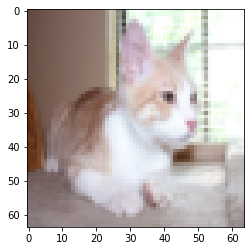

In [16]:
# Example of a picture
#print(test_x_orig.shape)
index = 12
#plt.imshow(test_x_orig[index])
#print ("y = " + str(train_y[0,index]) + ". It's a " + classes[test_y[0,index]].decode("utf-8") +  " picture.")

for i in range (0,49):
    plt.imshow(test_x_orig[i])
    if predictions[0][index] == 1.0:
        print("CATTTTT")
    else:
        print("me think no cat")
    time.sleep(4)
    plt.imshow(test_x_orig[i])git
    #print(predictions[0][index])